# Pybites Community Branch Activity

I wanted to play around with a dataset and see what I could find out about it. I decided on analyzing the little bit of data that I could collect from Github without having to use an OAuth key, which limits it to just 300 events.

## To Run All of The Cells
You have the option of running each of the cells one at a time or you can just run them all in sequential order. Selecting a cell and either clicking on the **Run** button on the menu or using the key combination **Shift+Enter** will run the code in that cell if its code.

To run them all you will have to use the menu: ***Cell > Run All***

In [1]:
import json
from collections import Counter
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from dateutil.parser import parse
from matplotlib import rc
from matplotlib.pyplot import figure

In [2]:
data_location = Path.cwd().joinpath("data")

## Retrieving and Importing the Data

The following code will load the three event json files in the data directory if the data directory exists. If the direcotry is not found it will be created and the files will be pulled down from Github and then loaded into memory.

In [3]:
def retrieve_data():
    if not data_location.exists():
        data_location.mkdir()
    url = "https://api.github.com/repos/pybites/challenges/events?page={}&per_page=1000"
    for page in range(1, 4):
        response = requests.get(url.format(page))
        if response.ok:
            file_name = data_location.joinpath(f"events{page}.json")
            try:
                file_name.write_text(json.dumps(response.json()))
                print(f"  Created: {file_name.name}")
            except Exception as e:
                print(e)
        else:
            print(f"Something went wrong: [response.status_code]: {response.reason}")


def load_data():
    if data_location.exists():
        for page in range(1, 4):
            file_name = data_location.joinpath(f"events{page}.json")
            events.extend(json.loads(file_name.read_text()))
            print(f"  Loaded: {file_name.name}")
    else:
        print("Data directory was not found:")
        retrieve_data()
        load_data()

> NOTE: If you want to work with the latest data, just remove the data directory and all its contents to have it pulled down once again.

In [4]:
events = []
load_data()
print(f"Total Events Loaded: {len(events)}")

  Loaded: events1.json
  Loaded: events2.json
  Loaded: events3.json
Total Events Loaded: 300


## Parsing the Data

From what I hear, we should just get used to cleaning data up before we can use it and its no exception here. I'm interested in exploring a few key points from the data. Mostly I'm interested in the following:

* Pull Request Events
* Data that they were created
* The username of the developer
* The amount of time spent on the challenge
* How difficult they found the challenge to be

In [5]:
# helper function
def parse_data(line):
    if '[' in line:
        data = line.split(': [')[1].replace(']', '').strip()
    else:
        data = line.split(': ')[1].strip()
    return data


# list to store the data
created = []
devs = []
diff_levels = []
time_spent = []

for event in events:
    # only insterested in pull request events
    if event['type'] == 'PullRequestEvent':
        # developer username
        dev = event['actor']['login']
        # ignore pybites ;)
        if dev != 'pybites':
            # store developer username
            devs.append(dev)
            # store the date
            created.append(event['created_at'].split('T')[0])
            # parse comment from user for data
            comment = event['payload']['pull_request']['body']
            for line in comment.split('\n'):
                # get difficulty level and time spent
                if 'Difficulty level (1-10):' in line:
                    diff = parse_data(line)
                elif 'Estimated time spent (hours):' in line:
                    spent = parse_data(line)
            # pandas DataFrames require that all columns are the same length
            # so if we have a missing value, None is used in its place
            if diff:
                diff_levels.append(int(diff))
            else:
                diff_levels.append(None)
            if spent:
                time_spent.append(int(spent))
            else:
                time_spent.append(None)

## Creating The DataFrame

Now that we have the lists with the data that we parsed, a DataFrame can be created with them.

In [6]:
df = pd.DataFrame({
    'Developers': devs, 
    'Difficulty_Levels': diff_levels, 
    'Time_Spent': time_spent,
    'Date': created,
})

## Data Exploration

Here, we can start exploring the data. To take a quick peek at how it's looking, there is no better choice then to use `head()`.

In [7]:
df.head()

,Developers,Difficulty_Levels,Time_Spent,Date
0,cod3Ghoul,4.0,20.0,2018-10-17
1,YauheniKr,4.0,2.0,2018-10-16
2,YauheniKr,4.0,2.0,2018-10-16
3,clamytoe,6.0,6.0,2018-10-15
4,vipinreyo,4.0,4.0,2018-10-15


To get some quick statistacaly metrics on the dataset, `describe()` can be used.

In [8]:
df.describe()

,Difficulty_Levels,Time_Spent
count,44.000000,44.000000
mean,3.681818,3.090909
std,1.639239,3.297767
min,1.000000,1.000000
25%,2.000000,1.000000
50%,4.000000,2.000000
75%,5.000000,4.000000
max,8.000000,20.000000


Based on what I could see above, I Wanted to get a feel for the following portions. I can see the average difficulty level above, next to the *50%*, but I also wanted to show you how to pull that out individually.

In [9]:
print(f'Developers: {len(df["Developers"])}')
print(f'Average Difficulty: {df["Difficulty_Levels"].median()}')
print(f'Time Spent: {df["Time_Spent"].sum()}')

Developers: 53
Average Difficulty: 4.0
Time Spent: 136.0


The following Counters are just me exploring the data even further.

In [10]:
developers = Counter(df['Developers']).most_common(6)
developers

[('clamytoe', 8),
 ('sorian', 8),
 ('vipinreyo', 7),
 ('demarcoz', 4),
 ('bbelderbos', 3),
 ('mridubhatnagar', 3)]

In [11]:
bite_difficulty = Counter(df['Difficulty_Levels'].dropna()).most_common()
bite_difficulty

[(4.0, 13), (2.0, 8), (3.0, 7), (6.0, 6), (5.0, 5), (1.0, 4), (8.0, 1)]

In [12]:
bite_duration = Counter(df['Time_Spent'].dropna()).most_common()
bite_duration

[(1.0, 16),
 (2.0, 10),
 (3.0, 6),
 (4.0, 4),
 (8.0, 3),
 (6.0, 2),
 (5.0, 2),
 (20.0, 1)]

In [13]:
created_at = sorted(Counter(df['Date'].dropna()).most_common())
created_at

[('2018-10-01', 1),
 ('2018-10-02', 6),
 ('2018-10-03', 3),
 ('2018-10-04', 4),
 ('2018-10-05', 8),
 ('2018-10-07', 7),
 ('2018-10-08', 4),
 ('2018-10-09', 2),
 ('2018-10-10', 1),
 ('2018-10-11', 1),
 ('2018-10-12', 4),
 ('2018-10-13', 3),
 ('2018-10-14', 3),
 ('2018-10-15', 3),
 ('2018-10-16', 2),
 ('2018-10-17', 1)]

Hmm, how many days are we looking at?

In [14]:
len(created_at)

16

## Time To Get Down To Business
Now that we've loaded our data and cleaned it up, lets see what it can tell us.

### Number of Pull Request per Day

Pretty amazing that [Pybites Blog Challenges](https://codechalleng.es/challenges/) had over **300** distinct github interactions in such a short time!

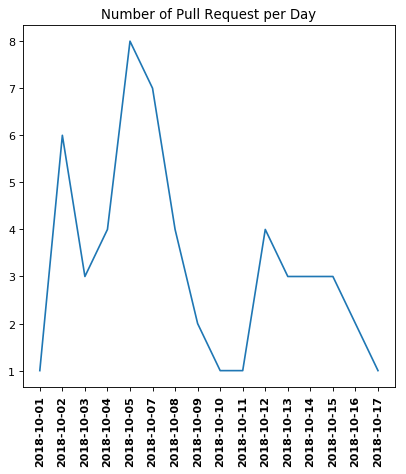

In [15]:
# resize graph
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

# gather data into a custom DataFrame
dates = [day[0] for day in created_at]
prs = [pr[1] for pr in created_at]
df_prs = pd.DataFrame({'xvalues': dates, 'yvalues': prs})
 
# plot
plt.plot('xvalues', 'yvalues', data=df_prs)

# labels
plt.xticks(rotation='vertical', fontweight='bold')

# title
plt.title('Number of Pull Request per Day')

# show the graphic
plt.show()

### Top Blog Challenge Ninjas

Although there are many more contributors, I had to limit the count so that the data would be easier to visualize.

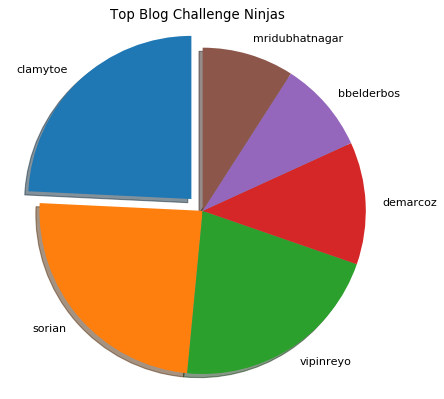

In [16]:
# resize graph
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

# create labels
labels = [dev[0] for dev in developers]

# get a count of the pull requests
prs = [dev[1] for dev in developers]

# pull out top ninja slice
explode = [0] * len(developers)
explode[0] = 0.1

# create the pie chart
plt.pie(prs, explode=explode, labels=labels, shadow=True, startangle=90)

# add title and center
plt.axis('equal')
plt.title('Top Blog Challenge Ninjas')

# show the graphic
plt.show()

### Time Spent vs Difficulty Level per Pull Request

Finally I wanted to explore what the relation between time spent per PR vs how difficult the develop found the challenge to be.

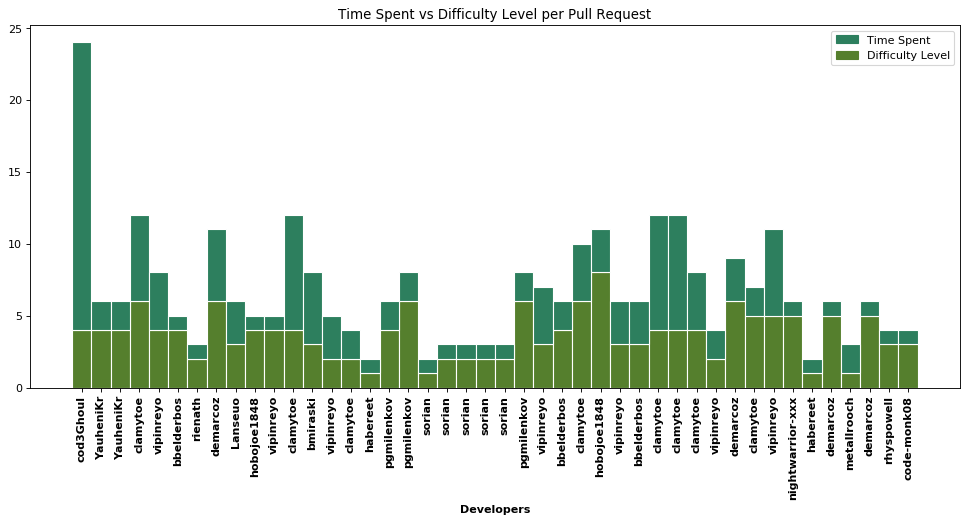

In [17]:
# resize graph
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

# drop null values
df_clean = df.dropna()

# add legend
diff = mpatches.Patch(color='#557f2d', label='Difficulty Level')
time = mpatches.Patch(color='#2d7f5e', label='Time Spent')
plt.legend(handles=[time, diff])

# y-axis in bold
rc('font', weight='bold')

# values of each group
bars1 = df_clean['Difficulty_Levels']
bars2 = df_clean['Time_Spent']

# heights of bars1 + bars2
bars = df_clean['Difficulty_Levels'] + df_clean['Time_Spent']

# position of the bars on the x-axis
r = range(len(df_clean))

# names of group and bar width
names = df_clean['Developers']
barWidth = 1

# create green bars (bottom)
plt.bar(r, bars1, color='#557f2d', edgecolor='white', width=barWidth)
# create green bars (top), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#2d7f5e', edgecolor='white', width=barWidth)

# custom X axis
plt.xticks(r, names, rotation='vertical', fontweight='bold')
plt.xlabel("Developers", fontweight='bold')

# title
plt.title('Time Spent vs Difficulty Level per Pull Request')

# show graphic
plt.show()

## Conclusions

As you can see, the Pybites Ninjas are an active bunch. With such a small limited dataset its plain to see that some good information can be extracted from it. Would be interesting to see which challenges are getting the most action though, but I'll leave that as an exercise for you to explore!